#    Compilers and Languages
## Programming assignment : Part 1 : input regex -> NFA

Table of Contents:
1. [The Shunting Yard Algorithm](#1.-Introduction---Shunting-Yard-Algorithm)
2. [Postfix to NFA](#2.-Postfix-to-NFA)

# The shunting yard algorithm (infix to postfix)

### Introduction
The shunting yard algorithm is a method for parsing mathematical expressions specified in infix notation. It can be used to produce output in Reverse Polish Notation (RPN) or as an abstract syntax tree (AST). The algorithm was invented by Edsger Dijkstra and named the "shunting yard" algorithm because its operation resembles that of a railroad shunting yard.

We will use the shunting yard algorithm to convert the regular expression to postfix notation, which will be used to create the NFA.

### Goal
converting something like `(A+B) * (C | D)` to `A+B . * CD |.`

### Features
. No recursion => Iterative approach.
. No trees are needed.
. No Ambiguities.
. Handles precedence of operators.

### Data Structures
1. infix (input regex) : The regular expression in infix notation (string)
   . Note : infix means the operator is between the operands. eg: `A+B` (The normal way we write expressions)
2. postfix : The regular expression in postfix notation (string)
    . Note : postfix means the operator is after the operands. eg: `AB+` (The way we write expressions in the shunting yard algorithm)
3. stack : The stack used in the algorithm (list)

### Algorithm
0. preprocess the infix to add a `.` between the operands where needed. (eg: `A(B|C)` => `A.(B|C)`). also substitute ranges like `a-z` with the union of all the characters in the range.
1. Create an empty stack for operators. Create an empty list for the output.
2. For each character in the infix :
    - If char is `(` or `[` => push to stack
    - If char is `)` or `]` => pop from stack until nearest matching `(` or `[` , append to output
    - If char is an operator => pop from stack until the top of the stack has a lower precedence than the current operator, then push the current operator to the stack
    - If char is an operand/normal character => append to output
3. Pop all the remaining operators from the stack and append to the output


In [263]:
# Important declarations
# -----------------------
# Dictionary containing the precedence of the operators
regex_operators_precedence = {
    '*' : 5,
    '+' : 4,
    '?' : 3,
    '.' : 2,
    '|' : 1,
    '(' : 0,
    ')' : 0
}

alphanumeric = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789_!'


## Preprocessing ...

In [264]:
# Utility functions
# -----------------
def preprocess_regex(regex):
    """
    Preprocess the regex to do the following:
        1-[ranges] add OR's | between in square brackets characters
        2-[ranges] replace dash - with the corresponding sequence of characters with OR's between them
        3-add the missing '.' operators
    """

    #step 0 : handle '.' operator ==> replace with [a-zA-Z0-9]
    regex = regex.replace('.', '[' + alphanumeric + ']')

    #step 1 : add OR's | between in square brackets characters without -
    square_brackets_open = False
    for i in range(len(regex)):
        if regex[i] == '[':
            square_brackets_open = True
        elif regex[i] == ']':
            square_brackets_open = False
        elif square_brackets_open and regex[i] != '-' and regex[i] in alphanumeric and i+1 < len(regex) and regex[i+1] in alphanumeric:
            regex = regex[:i+1] + '|' + regex[i+1:]
    print(f"After step 1 : {regex}")
    #step 2 : replace dash - with the corresponding sequence of characters with OR's between them
    i = 0
    while i < len(regex):
        c = regex[i]
        print(f"i = {i}, c = {c}")
        if c == '-':
            #pop the last element from the stack
            first = regex[i-1] if regex[i-1] in alphanumeric else None
            if not first:
                raise ValueError('Range error: element after - is not alphanumeric')
            #access Char + 1
            last = regex[i + 1] if i+1 < len(regex) and regex[i+1] in alphanumeric else None
            if not last:
                raise ValueError('Range error: element after - is not alphanumeric')
            #throw the - operator from the regex
            operating_list = []
            for char in alphanumeric:
                if alphanumeric.index(char) > alphanumeric.index(first) and alphanumeric.index(char) < alphanumeric.index(last):
                    #append | between the characters
                    # if char != last:
                    operating_list.append('|')
                    operating_list.append(char)
            operating_list.append('|')
            #replace - in regex with the operating list
            #using i to get the index of the first character in the range
            regex = regex[:i] + ''.join(operating_list) + regex[i+1:]
            i += len(operating_list)
        i += 1

    print(f"After step 2 : {regex}")
    #step 3 : add the missing '.' operators
    check1_list = ['*', '+', '?', ')', ']']
    new_regex = ''
    for i,c in enumerate(regex):
        if i > 0 and c in check1_list and i+1 < len(regex) and regex[i+1] not in check1_list and regex[i+1] != '|':
            new_regex += c + '.'
        elif c in alphanumeric and i+1 < len(regex) and ((regex[i+1] in alphanumeric) or regex[i+1] in ['(', '[']):
            new_regex += c + '.'
        else:
            new_regex += c
    print(f"After step 3 : {new_regex} Preprocessed!")
    return new_regex

In [265]:
def infix_to_postfix(regex):
    """
    Convert an infix regular expression to a postfix regular expression.

    Parameters:
    regex (str): The infix regular expression to convert to postfix.

    Returns:
    str: The postfix regular expression.
    """
    regex = preprocess_regex(regex)
    # Create a stack to hold the operators
    stack = []
    # Create a list to hold the postfix regular expression
    postfix = []
    # Iterate over the characters in the infix regular expression
    for index,char in enumerate(regex):
        #1. '(' or '[': Push it onto the stack
        if char == '(' or char == '[':
            stack.append(char)
        #2. ')' or ']': Pop operators from the stack and append them to the postfix list until '(' or '[' is found
        elif char == ')' :
            while stack[-1] != '(':
                postfix.append(stack.pop())
            #error handling : check empty stack
            if not stack:
                raise ValueError('Parentheses mismatch : found ")" in the stack without "("')
            stack.pop()
        elif char == ']':
            while stack[-1] != '[':
                postfix.append(stack.pop())
            #error handling : check empty stack
            if not stack:
                raise ValueError('Parentheses mismatch : found "]" in the stack without "["')
            stack.pop()
        #3. Operator: Pop operators from the stack and append them to the postfix list until an operator with lower precedence is found
        elif char in regex_operators_precedence:
            #checks:
            # 1. if the stack is not empty
            # 2. if the stack[-1] is an operator => meaning the last element in the stack is an operator
            # 3. if the precedence of the operator in the stack is greater than or equal to the precedence of the current operator
            while stack and stack[-1] in regex_operators_precedence and regex_operators_precedence[stack[-1]] >= regex_operators_precedence[char]:
                postfix.append(stack.pop())
            stack.append(char)
        #else: Append the character to the postfix list
        else:
            # A normal character => append it to the postfix list
            postfix.append(char)
        # empty the stack
    while stack:
        #error handling : check '(' in the stack
        if stack[-1] == '(':
            raise ValueError('Parentheses mismatch : found "(" in the stack without ")"')
        postfix.append(stack.pop())
    return ''.join(postfix)



In [266]:
# test cases
# ----------
def test (id,regex, expected_postfix):
    output =infix_to_postfix(regex)
    print(f"Test case #{id} : {regex} received : {output} expected : {expected_postfix} => Passed")
    assert output == expected_postfix

# test(1,'a+b*c', 'a+b*.c.')
# test(2,'[a-z]+', 'a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z+')
print(infix_to_postfix('[a-zA-Z]+'))
print(infix_to_postfix('[f-p0-9]+(a*bcd?|cde*)'))

print(infix_to_postfix('[a-c]?.(c|d)'))

print('All test cases passed!')

After step 1 : [a-z|A-Z]+
i = 0, c = [
i = 1, c = a
i = 2, c = -
i = 52, c = |
i = 53, c = A
i = 54, c = -
i = 104, c = ]
i = 105, c = +
After step 2 : [a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z]+
After step 3 : [a|b|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z]+ Preprocessed!
ab|c|d|e|f|g|h|i|j|k|l|m|n|o|p|q|r|s|t|u|v|w|x|y|z|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|+
After step 1 : [f-p|0-9]+(a*bcd?|cde*)
i = 0, c = [
i = 1, c = f
i = 2, c = -
i = 22, c = |
i = 23, c = 0
i = 24, c = -
i = 42, c = ]
i = 43, c = +
i = 44, c = (
i = 45, c = a
i = 46, c = *
i = 47, c = b
i = 48, c = c
i = 49, c = d
i = 50, c = ?
i = 51, c = |
i = 52, c = c
i = 53, c = d
i = 54, c = e
i = 55, c = *
i = 56, c = )
After step 2 : [f|g|h|i|j|k|l|m|n|o|p|0|1|2|3|4|5|6|7|8|9]+(a*bcd?|cde*)
After step 3 : [f|g|h|i|j|k|l|m|n|o|p|0|1|2|3|4|5|6|7|8|9]+.(a*.b.c.d?|c.d.e*) Preprocessed!
fg|h

# Postfix to NFA

## OOP Classes

### edge
1. label : The label of the edge
2. destination : The destination state of the edge
### state
1. label : The label of the state
2. out_edges : The outgoing edges from the state

### NFA
1. start : The start state of the NFA
2. accept : The accept state of the NFA
3. inner_states : The inner states of the NFA

In [267]:
import sys
import json
sys.path.append('../pkg')  # Add the parent directory of pkg to the Python path
from classes import NFA, NFA_state, edge, SuperState, DFA, LowerTriangularMatrix

## Algorithm
### Based on Thompson's construction algorithm
1. Create a stack for NFA fragments
2. For each character in the postfix :
   1. If char is an operand/normal character => create a new NFA fragment with the character as the label and push to stack
   2. If char is a `.` => pop 2 fragments from the stack, connect the accept state of the first fragment to the start state of the second fragment, and push the new fragment to the stack
   3. If char is a `|` => pop 2 fragments from the stack, create a new start state and connect it to the start states of the 2 fragments, create a new accept state and connect the accept states of the 2 fragments to the new accept state, and push the new fragment to the stack
   4. If char is a `*` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and connect the accept state of the fragment to the start state of the fragment, and push the new fragment to the stack
   5. If char is a `+` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and connect the accept state of the fragment to the start state of the fragment, and push the new fragment to the stack
   6. If char is a `?` => pop 1 fragment from the stack, create a new start state and connect it to the start state of the fragment, create a new accept state and connect the accept states of the fragment to the new accept state, and push the new fragment to the stack
3. The final NFA is the fragment left in the stack

In [268]:
# Important functions [Thomas Construction Algorithm]
# -------------------
'''
1. Create a new NFA for a given character
2. Concatenate two NFAs
3. Union of two NFAs
4. Zero or more of an NFA
5. One or more of an NFA
6. Zero or one of an NFA
'''

def create_nfa(char: str, id: int ,fragment_stack):
    '''
    Create a new NFA for a given character

    Parameters:
    char (str): The character to create the NFA for.
    id (int): The id of the new NFA, used to label the states.
    fragment_stack (list): The stack of NFA fragments.

    Returns:
    NFA: The NFA for the given character.
    '''
    #create two states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    #Dummy label in format of S0 , S1, S2, ...
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create an edge from initial to accept with the given character
    edg = edge()
    edg.label = char
    edg.destination = accept
    initial.out_edges.append(edg)
    #push the new NFA to the stack
    created_nfa = NFA(initial, accept, [initial, accept])
    fragment_stack.append(created_nfa)
    id += 2
    return created_nfa

def concatenate_nfas(fragment_stack):
    '''
    Concatenate two NFAs, popping them from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.

    Returns:
    NFA: The NFA resulting from concatenating the top two NFAs on the stack.
    '''
    #pop the top two NFAs from the stack
    nfa2 = fragment_stack.pop()
    nfa1 = fragment_stack.pop()
    #create an edge from the accept state of the first NFA to the start state of the second NFA
    edg = edge()
    edg.label = "ε"
    edg.destination = nfa2.start
    nfa1.accept.out_edges.append(edg)
    #push the concatenated NFA back to the stack
    concatenated_nfa = NFA(nfa1.start, nfa2.accept, nfa1.inner_states + nfa2.inner_states)
    fragment_stack.append(concatenated_nfa)
    return concatenated_nfa

def union_nfas(fragment_stack , id : int):
    '''
    Union of two NFAs, popping them from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from union of the top two NFAs on the stack.
    '''
    #pop the top two NFAs from the stack
    nfa2 = fragment_stack.pop()
    nfa1 = fragment_stack.pop()
    #create two new states for the new NFA
    '''
    [S0] --ε--> [nfa1.start] --ε--> [S1]
        |ε                          |
        ----> [nfa2.start] --  ε  --|
    '''
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start states of the two NFAs
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa1.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = nfa2.start
    initial.out_edges.append(edg2)
    #create two edges from the accept states of the two NFAs to the new accept state
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = accept
    nfa1.accept.out_edges.append(edg3)
    edg4 = edge()
    edg4.label = "ε"
    edg4.destination = accept
    nfa2.accept.out_edges.append(edg4)
    #push the union NFA back to the stack
    union_nfa = NFA(initial, accept, [initial, accept] + nfa1.inner_states + nfa2.inner_states )
    fragment_stack.append(union_nfa)
    id += 2
    return union_nfa

def zero_or_more_nfa(fragment_stack, id: int):
    '''
    Zero or more of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from zero or more of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start state of the NFA and to the new accept state
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    initial.out_edges.append(edg2)
    #create two edges from the accept state of the NFA to the new accept state and to the initial state of the new NFA
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = initial
    nfa.accept.out_edges.append(edg3)
    edg4 = edge()
    edg4.label = "ε"
    edg4.destination = accept
    nfa.accept.out_edges.append(edg4)
    #push the zero or more NFA back to the stack
    zero_or_more_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(zero_or_more_nfa)
    id += 2
    return zero_or_more_nfa

def one_or_more_nfa(fragment_stack, id: int):
    '''
    One or more of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from one or more of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create an edge from the new initial state to the start state of the NFA
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    #create two edges from the accept state of the NFA to the new accept state and to the initial state of the new NFA
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    nfa.accept.out_edges.append(edg2)
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = initial
    nfa.accept.out_edges.append(edg3)
    #push the one or more NFA back to the stack
    one_or_more_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(one_or_more_nfa)
    id += 2
    return one_or_more_nfa

def zero_or_one_nfa(fragment_stack, id: int):
    '''
    Zero or one of an NFA, popping it from the stack and pushing the result back.

    Parameters:
    fragment_stack (list): The stack of NFA fragments.
    id (int): The id of the new NFA, used to label the states.

    Returns:
    NFA: The NFA resulting from zero or one of the top NFA on the stack.
    '''
    #pop the top NFA from the stack
    nfa = fragment_stack.pop()
    #create two new states for the new NFA
    initial = NFA_state()
    accept = NFA_state()
    initial.label = f"S{id}"
    accept.label = f"S{id+1}"
    #create two edges from the new initial state to the start state of the NFA and to the new accept state
    edg1 = edge()
    edg1.label = "ε"
    edg1.destination = nfa.start
    initial.out_edges.append(edg1)
    edg2 = edge()
    edg2.label = "ε"
    edg2.destination = accept
    initial.out_edges.append(edg2)
    #create an edge from the accept state of the NFA to the new accept state
    edg3 = edge()
    edg3.label = "ε"
    edg3.destination = accept
    nfa.accept.out_edges.append(edg3)
    #push the zero or one NFA back to the stack
    zero_or_one_nfa = NFA(initial, accept, [initial, accept] + nfa.inner_states)
    fragment_stack.append(zero_or_one_nfa)
    id += 2
    return zero_or_one_nfa


In [269]:
def thompson_construction_postfix_to_nfa(postfix):
    '''
    Convert a postfix regular expression to an NFA using the Thompson construction algorithm.

    Parameters:
    postfix (str): The postfix regular expression to convert to an NFA.

    Returns:
    NFA: The NFA resulting from the postfix regular expression.
    '''
    # Create an empty stack to hold the NFA fragments
    fragment_stack = []
    #dummy id for the states
    id = 0
    # Iterate over the characters in the postfix regular expression
    for char in postfix:
        if char in alphanumeric:
            create_nfa(char, id, fragment_stack)
        elif char == '.':
            concatenate_nfas(fragment_stack)
        elif char == '|':
            union_nfas(fragment_stack, id)
        elif char == '*':
            zero_or_more_nfa(fragment_stack, id)
        elif char == '+':
            one_or_more_nfa(fragment_stack, id)
        elif char == '?':
            zero_or_one_nfa(fragment_stack, id)
        else:
            raise ValueError(f'Invalid character in postfix regular expression: {char}')
        id += 2
    #adjust IDs
    normal_id = 0
    for i, state in enumerate(fragment_stack[0].inner_states):
        #if not accept state
        if state != fragment_stack[0].accept:
            state.label = f"S{normal_id}"
            normal_id += 1
    fragment_stack[0].accept.label = f"S{normal_id}"
    # Return the resulting NFA
    return fragment_stack.pop()



In [270]:
# Output NFA to JSON of the following format:
'''
{
"startingState": "S0",
"S0": {
"isTerminatingState": false,
"A": "S1",
"B": "S0"
},
"S1": {
"isTerminatingState": true,
"A": "S1",
"B": "S1"
}
}


'''

def nfa_to_json(nfa):
    '''
    Convert an NFA to a JSON representation.

    Parameters:
    nfa (NFA): The NFA to convert to JSON.

    Returns:
    str: The JSON representation of the NFA.
    '''
    output_json = dict()
    output_json["starting_state"] = nfa.start.label
    for stat in nfa.inner_states:
      stateDict = dict()
      if stat == nfa.accept:
        stateDict["is_terminating_state"] = True
      else:
        stateDict["is_terminating_state"] = False
      for edg in stat.out_edges:
        if(edg.label in stateDict.keys()):
          stateDict[edg.label] = [] + [stateDict[edg.label]] + [edg.destination.label]
        else:
          stateDict[edg.label] = edg.destination.label
      output_json[stat.label] = stateDict
    nfaOutFile = open('NFA.json', 'w', encoding="utf-8")
    Json_object = json.dump(output_json, nfaOutFile,indent=6, ensure_ascii=False)
    nfaOutFile.close()
    return Json_object


In [271]:
# Test cases
# ----------
# def test_postfix_to_nfa(id, postfix, expected_nfa):
#     nfa = thompson_construction_postfix_to_nfa(postfix)
#     print(f"Test case #{id} : {postfix} received : {nfa} expected : {expected_nfa} => Passed")
#     assert nfa == expected_nfa

# # Test case 1
# regex = 'a|b*'
# postfix = infix_to_postfix(regex)
# nfa = thompson_construction_postfix_to_nfa(postfix)
# nfa.print_graph()
# print(nfa_to_json(nfa))
# nfa.visualize()

# Testing Cell : user input

After step 1 : (((((ABE)|C)|((([A-C])S)*))+)((AB)C))
i = 0, c = (
i = 1, c = (
i = 2, c = (
i = 3, c = (
i = 4, c = (
i = 5, c = A
i = 6, c = B
i = 7, c = E
i = 8, c = )
i = 9, c = |
i = 10, c = C
i = 11, c = )
i = 12, c = |
i = 13, c = (
i = 14, c = (
i = 15, c = (
i = 16, c = [
i = 17, c = A
i = 18, c = -
i = 22, c = ]
i = 23, c = )
i = 24, c = S
i = 25, c = )
i = 26, c = *
i = 27, c = )
i = 28, c = )
i = 29, c = +
i = 30, c = )
i = 31, c = (
i = 32, c = (
i = 33, c = A
i = 34, c = B
i = 35, c = )
i = 36, c = C
i = 37, c = )
i = 38, c = )
After step 2 : (((((ABE)|C)|((([A|B|C])S)*))+)((AB)C))
After step 3 : (((((A.B.E)|C)|((([A|B|C]).S)*))+).((A.B).C)) Preprocessed!
postfix =  AB.E.C|AB|C|S.*|+AB.C..
NFA graph:
State S0 :
  edge ε going to S2
State S1 :
  edge ε going to S28
State S2 :
  edge ε going to S4
  edge ε going to S14
State S3 :
  edge ε going to S1
  edge ε going to S0
State S4 :
  edge ε going to S6
  edge ε going to S12
State S5 :
  edge ε going to S3
State S6 :
  edge A

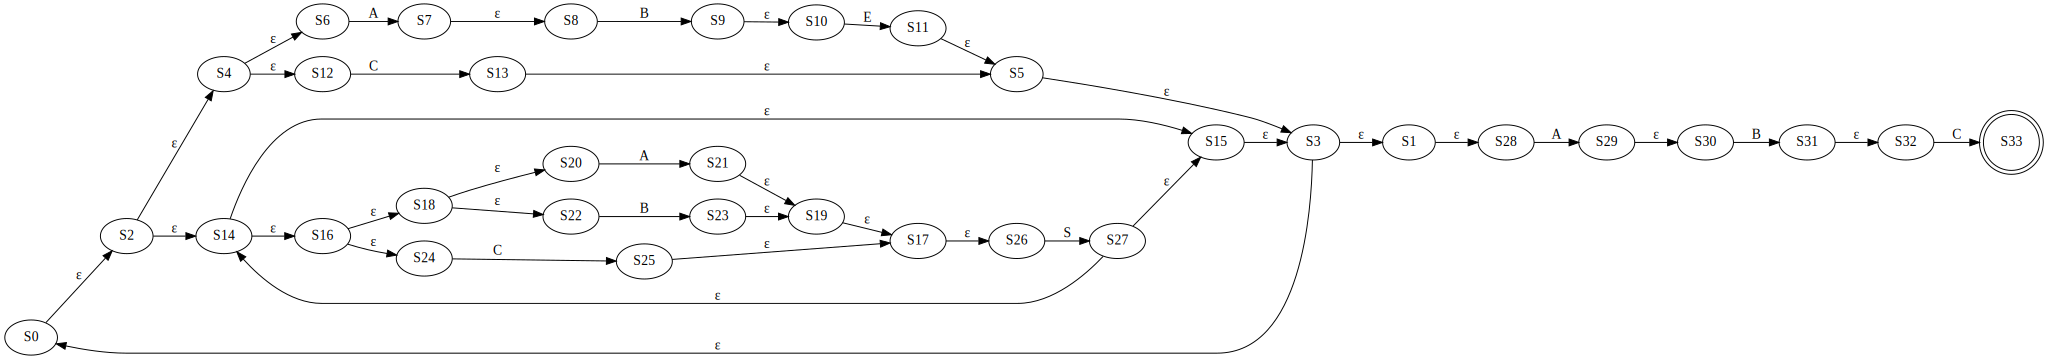

In [272]:
def test_user_input():
    regex = input("Enter a regular expression: ")
    postfix = infix_to_postfix(regex)
    print("postfix = ", postfix) 
    nfa = thompson_construction_postfix_to_nfa(postfix)
    nfa.print_graph()
    nfa_to_json(nfa)
    print("NFA saved to NFA.json")
    return nfa, postfix

nfa, postfix = test_user_input()
nfa.visualize()

In [273]:
def get_input_characters(postfix: str) -> list[str]:
    input_chars = []
    escaped_flag = False
    for c in postfix:
        if c in alphanumeric or escaped_flag:
            input_chars.append(c)
            escaped_flag = False
        if c == '/':
            escaped_flag = True
    return input_chars


def powerset_construction(nfa: NFA, alphabet: str) -> DFA:
    dfa = DFA(nfa)
    unmarked_states = set()
    unmarked_states.add(dfa.start_super_state)
    while unmarked_states:
        current_super_state:SuperState = unmarked_states.pop()
        for char in alphabet:
            generated_super_state = current_super_state.generate_new_superstate(char)
            
            if generated_super_state and generated_super_state.sub_states:
                existing_super_state = dfa.get_super_state(generated_super_state)
                if not existing_super_state:
                    new_super_state = SuperState()
                    new_super_state.sub_states = generated_super_state.sub_states
                    new_super_state.label = "S" + str(len(dfa.super_states))
                    dfa.super_states.add(new_super_state)
                    unmarked_states.add(new_super_state)
                    current_super_state.out_edges.append(edge(char, new_super_state)) 
                else:
                    current_super_state.out_edges.append(edge(char, existing_super_state))

    for super_state in dfa.super_states:
        for sub_state in super_state.sub_states:
            if sub_state == nfa.accept:
                super_state.is_end = True
                dfa.accept_super_states.add(super_state)

    return dfa

In [274]:
def create_nfa_state(state_label:str) -> NFA_state:
    nfa_state = NFA_state()
    nfa_state.label = state_label
    return nfa_state

def min_DFA(dfa: DFA, input_chars: str) -> DFA:
    #initialize the lower triangular matrix
    lower_tri_matrix = LowerTriangularMatrix(len(dfa.super_states))
    lower_tri_matrix.fill_with_dfa(dfa)
    lower_tri_matrix.iterate_to_min_dfa(dfa, input_chars)
    new_dfa = DFA()

    # dictionary of [int, set]
    new_states = dict()
    id = 0
    for pair in lower_tri_matrix.pairs.keys():
        if lower_tri_matrix.get(pair[0], pair[1]) == "∅":
            s0 = dfa.get_super_state_from_label(pair[0])
            s1 = dfa.get_super_state_from_label(pair[1])

            # if the new_states is empty => create a new set
            if not new_states:
                new_states[id] = {s0, s1}
                id += 1
            else:
                # check if the pair[0] or pair[1] are in any of the sets
                found = False
                for key in new_states.keys():
                    if s0 in new_states[key] or s1 in new_states[key]:
                        new_states[key].add(s0)
                        new_states[key].add(s1)
                        found = True
                        break
                if not found:
                    new_states[id] = {s0, s1}
                    id += 1

    # iterate over the matrix to add the states that does not appear in the dictionary values
    for pair in lower_tri_matrix.pairs.keys():
        if lower_tri_matrix.get(pair[0], pair[1]) != "∅":
            s0 = dfa.get_super_state_from_label(pair[0])
            s1 = dfa.get_super_state_from_label(pair[1])
            found_1 = False
            for key in new_states.keys():
                if s0 in new_states[key]:
                    found_1 = True
                    break
            if not found_1:
                new_states[id] = {s0}
                id += 1

            found_2 = False
            for key in new_states.keys():
                if s1 in new_states[key]:
                    found_2 = True
                    break
            if not found_2:
                new_states[id] = {s1}
                id += 1


    # create a new dictionary the key is the representitive of the superstate and the value is a list of the superstates
    super_states_with_representatives = dict()
    for key in new_states.keys():
        curr_states_list = list(new_states[key])
        representativ_state = curr_states_list[0]
        super_states_with_representatives[representativ_state.label] = curr_states_list

    new_super_states = set()
    # Create SuperStates for each representitive and connect the edges from each representitive to other representitives
    for key in super_states_with_representatives.keys():
        super_state = SuperState()
        super_state.label = key
        representative = super_states_with_representatives[key][0]
        for repr_edge in representative.out_edges:
            curr_dest = repr_edge.destination
            dest_representative = None
            for key in super_states_with_representatives.keys():
                if curr_dest in super_states_with_representatives[key]:
                    dest_representative = super_states_with_representatives[key][0]
                    break
            if dest_representative:
                
                super_state.out_edges.append(edge(repr_edge.label, dest_representative))

        # print the current state and its output edges:
        print(f"State : {super_state.label}")
        for e in super_state.out_edges:
            print(f"Edge : {e.label} -> {e.destination.label}")
        new_super_states.add(super_state)

        




    # set the start state, loop over the super_states_with_representatives to find the start state
    for key in super_states_with_representatives.keys():
        found_start = False
        if dfa.start_super_state in super_states_with_representatives[key]:
            # get this representitive from the new_super_states
            for state in new_super_states:
                if state.label == key:
                    new_dfa.start_super_state = state
                    found_start = True
                    break
        if found_start:
            break
    
    # set the accept states, loop over the super_states_with_representatives to find the accept states
    for key in super_states_with_representatives.keys():
        found_accept = False
        for accept_state in dfa.accept_super_states:
            if accept_state in super_states_with_representatives[key]:
                # get this representitive from the new_super_states
                for state in new_super_states:
                    if state.label == key:
                        new_dfa.accept_super_states.add(state)
                        found_accept = True
                        break
            if found_accept:
                break

    new_dfa.super_states = new_super_states

    return new_dfa



In [275]:
def construct_minDFA_Json (dfa: DFA):
      output_json = dict()
      for ss in dfa.super_states:
        if(ss.is_start):
          output_json["starting_state"] = ss.label
        state_dict = dict()
        if ss.is_end:
          state_dict["is_terminating_state"] = True
        else:
          state_dict["is_terminating_state"] = False
        for edg in ss.out_edges:
          if(edg.label in state_dict.keys()):
            state_dict[edg.label] = [] + [state_dict[edg.label]] + [edg.destination.label]
            #state_dict[edg.label].append(edg.destination)
          else:
            state_dict[edg.label] = edg.destination.label
        output_json[ss.label] = state_dict
      minDFA_out_file = open('minDFA.json', 'w')
      json_obj = json.dump(output_json, minDFA_out_file,indent=6, ensure_ascii=False)
      minDFA_out_file.close()
      return json_obj

In [276]:
input_chars = get_input_characters(postfix)
dfa = powerset_construction(nfa, input_chars)
dfa.visualize_normal()
dfa.visualize('DFA Cleaned')

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
min_dfa = min_DFA(dfa, input_chars)


min_dfa.visualize("minDFA")
construct_minDFA_Json(min_dfa)

State : S7
Edge : a -> S7
Edge : b -> S7
Edge : c -> S7
Edge : _ -> S7
Edge : a -> S7
Edge : b -> S7
Edge : c -> S7
Edge : 0 -> S7
Edge : 1 -> S7
Edge : 2 -> S7
Edge : 3 -> S7
Edge : _ -> S7
Edge : ! -> S15
State : S0
Edge : a -> S7
Edge : b -> S7
Edge : c -> S7
Edge : d -> S7
Edge : e -> S7
Edge : _ -> S7
Edge : a -> S7
Edge : b -> S7
Edge : c -> S7
Edge : _ -> S7
State : S15
